# To begin

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
%matplotlib inline
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
from GCRCatalogs import GCRQuery
import numpy as np
from matplotlib.patches import Rectangle
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
import sys
import os
import shutil
import pickle
import healpy as hp
import h5py
import pandas as pd

###clevar
import clevar
from clevar import ClCatalog
from clevar.match import ProximityMatch
from clevar.match_metrics import scaling
from clevar.match_metrics import recovery
from clevar.match_metrics import distances
from clevar.match import get_matched_pairs
from clevar.match import output_matched_catalog


### Loading Matching's results

In [3]:
all_amico_data_members = Table.read('/sps/lsst/groups/clusters/amico_validation_project/catalogs/amico_cats/new_amico_map_associations_cut/all_maps_cut.fits')

In [4]:
all_amico_data_members

mb_id,cl_id,prob,uid,ra,dec,z,lambstar,SN
int64,int64,float32,float64,float64,float64,float64,float64,float64
8937506729,5,0.29497647,19317.0,65.701707,-38.11734,0.5299999713897705,64.097006,8.8714556
8937513364,5,0.28917313,19317.0,65.701707,-38.11734,0.5299999713897705,64.097006,8.8714556
8937514977,5,0.07473981,19317.0,65.701707,-38.11734,0.5299999713897705,64.097006,8.8714556
8937519516,5,0.17177144,19317.0,65.701707,-38.11734,0.5299999713897705,64.097006,8.8714556
8937520312,5,0.07378859,19317.0,65.701707,-38.11734,0.5299999713897705,64.097006,8.8714556
8937520815,5,0.09998231,19317.0,65.701707,-38.11734,0.5299999713897705,64.097006,8.8714556
8937522109,5,0.022967089,19317.0,65.701707,-38.11734,0.5299999713897705,64.097006,8.8714556
8937522427,5,0.27252233,19317.0,65.701707,-38.11734,0.5299999713897705,64.097006,8.8714556
8937524520,5,0.18709254,19317.0,65.701707,-38.11734,0.5299999713897705,64.097006,8.8714556


In [5]:
cl_inpath = '/sps/lsst/groups/clusters/amico_validation_project/catalogs/130323/cosmoDC2_small_photoz_flexzboost_v0/map_detections_refined_noBuffer_all_noDoubles.fits'
amico_cl_data = Table.read(cl_inpath)['ID', 'Xphys', 'Yphys', 'Zphys','LAMBSTAR', 'SN_NO_CLUSTER', 'SN', 'UID', 'TILE', 'LAMB', 'AMP']  

In [6]:
amico_cl_data

ID,Xphys,Yphys,Zphys,LAMBSTAR,SN_NO_CLUSTER,SN,UID,TILE,LAMB,AMP
int16,float64,float64,float32,float64,float64,float64,int16,int16,float64,float64
2,61.379151,-39.997938,0.76,151.05119,87.011334,10.992644,1,10070,563.08723,5.0676804
4,61.751903,-39.598934,0.39,34.635494,45.503782,8.6246391,2,10070,325.80262,1.894689
7,62.020461,-40.78391,0.76,65.485061,47.128286,8.0360327,3,10070,277.82817,2.7448274
10,62.622221,-40.86162,0.26,35.691697,30.95731,7.1248405,4,10070,237.63314,1.1784459
11,61.527245,-40.393481,0.74,49.109488,35.746636,7.0846547,5,10070,259.19082,2.065701
13,62.669286,-39.811269,0.38,22.831824,26.760903,6.6516001,6,10070,208.87301,1.1190241
16,61.321316,-40.68769,1.33,40.708297,41.626933,6.4476733,7,10070,151.75732,2.9380938
18,61.378259,-41.012951,0.44,26.0136,33.226036,6.4235022,8,10070,280.16731,1.3014746
19,61.503286,-41.168414,0.38,24.052439,24.999905,6.4150788,9,10070,219.63575,1.0453868


In [8]:
z_l = [.1,.3,.45,.6,.8,.9]

In [20]:
colors = ['b', 'g', 'm','r','tab:orange']

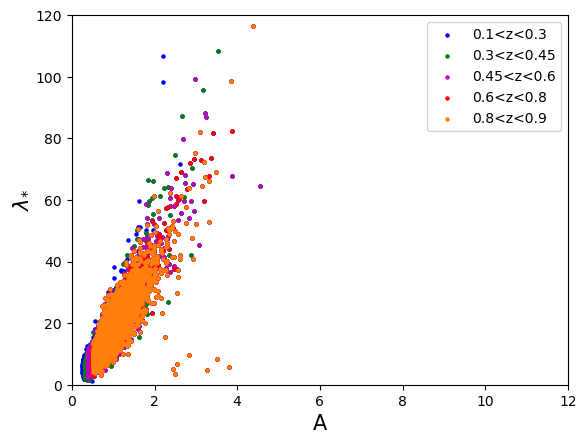

In [25]:
for i in range(1,len(z_l)):
    z_min = z_l[i-1]
    z_max = z_l[i]
    amico_cl_cdt = amico_cl_data[(amico_cl_data['SN']>2)*(amico_cl_data['Zphys']>z_min)*(amico_cl_data['Zphys']>z_max)]
    plt.scatter(amico_cl_cdt['AMP'], amico_cl_cdt['LAMBSTAR'], label = str(z_min) + '<z<' + str(z_max), s=5, color = colors[i-1])
plt.xlabel('A', fontsize = 15)
plt.ylabel('$\lambda_{*}$', fontsize = 15)
plt.ylim([0,120])
plt.xlim([0,12])
plt.legend()

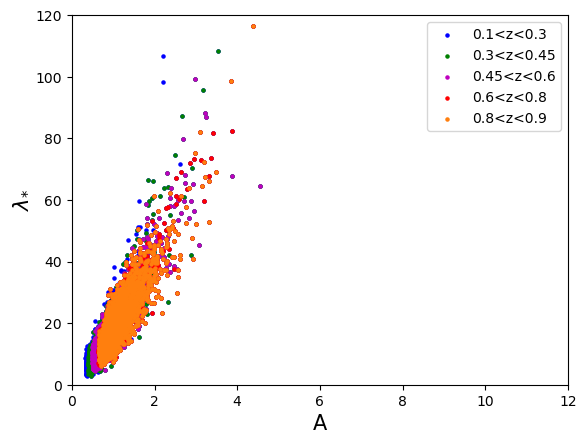

In [26]:
for i in range(1,len(z_l)):
    z_min = z_l[i-1]
    z_max = z_l[i]
    amico_cl_cdt = amico_cl_data[(amico_cl_data['SN']>3.5)*(amico_cl_data['Zphys']>z_min)*(amico_cl_data['Zphys']>z_max)]
    plt.scatter(amico_cl_cdt['AMP'], amico_cl_cdt['LAMBSTAR'], label = str(z_min) + '<z<' + str(z_max), s=5, color = colors[i-1])
plt.xlabel('A', fontsize = 15)
plt.ylabel('$\lambda_{*}$', fontsize = 15)
plt.ylim([0,120])
plt.xlim([0,12])
plt.legend()

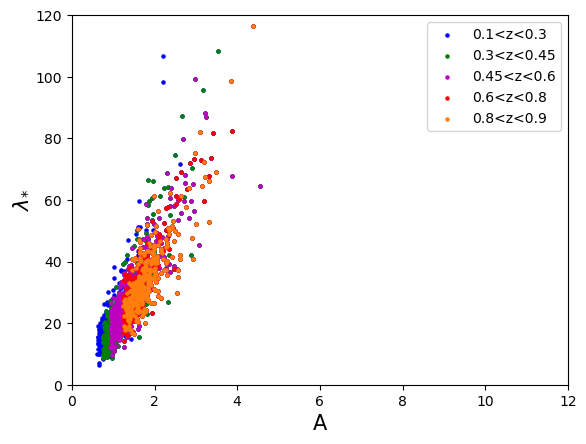

In [27]:
for i in range(1,len(z_l)):
    z_min = z_l[i-1]
    z_max = z_l[i]
    amico_cl_cdt = amico_cl_data[(amico_cl_data['SN']>5.0)*(amico_cl_data['Zphys']>z_min)*(amico_cl_data['Zphys']>z_max)]
    plt.scatter(amico_cl_cdt['AMP'], amico_cl_cdt['LAMBSTAR'], label = str(z_min) + '<z<' + str(z_max), s=5, color = colors[i-1])
plt.xlabel('A', fontsize = 15)
plt.ylabel('$\lambda_{*}$', fontsize = 15)
plt.ylim([0,120])
plt.xlim([0,12])
plt.legend()